In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

In [295]:
class LIFNeuron(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 c_m = 1, r_m = 10, v_reset = -75, refrac_time = 10, v_th = -54, e_l = -75, i_e = 0, dt = 0.05,
                 g_ampa = 0, g_gaba = 0,
                 n_gaba_inputs = 0, n_ampa_inputs = 0,
                 allow_spiking = True,
                ):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()

        ### assign the attributes of the class
        self.r_m = r_m # membrane resistance in M Ohm/cm**2
        self.tau_m = self.r_m * c_m  # membrane time constant
        self.e_l = e_l # leak reversal potential

        
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.i_e = i_e # Input current


        self.v = self.e_l # starting voltage value for the simulation
        self.dt = dt # simulation timestep    

        
        ''' refractory period '''
        self.refrac_time = refrac_time # in ms
        self.refrac_tracker = 0
        ''' refractory period '''
        
        self.v_list = [self.v]
        self.t_list = [0]
        self.i_e_list = [self.i_e]
        
        self.spike_times = []
        self.allow_spiking = allow_spiking
        
        
        ### Initiate synaptic paramters
        self.ps_ampa = np.zeros(n_ampa_inputs) # when starting the simulations the channels should be closed
        self.ampa_input = np.zeros(n_ampa_inputs).astype(bool) # and there is no input
        self.g_ampa = np.ones(n_ampa_inputs)*g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = np.zeros(n_gaba_inputs) # when starting the simulations the channels should be closed
        self.gaba_input = np.zeros(n_gaba_inputs).astype(bool) # and there is no input
        self.g_gaba = np.ones(n_gaba_inputs)*g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms
        


    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        
        ### Time evolution of the synaptic input
        
        # first the decay
        dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
        self.ps_ampa += dps_ampa_dt * self.dt

        # then we set the open channels to 1
        self.ps_ampa[self.ampa_input == True] = 1 # if there is a spike in this time step, the channels open
        self.ampa_input[:] = False # remove the input 
        
        
        # first the decay
        dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
        self.ps_gaba += dps_gaba_dt * self.dt
        
        # then we set the open channels to 1
        self.ps_gaba[self.gaba_input == True] = 1 # if there is a spike in this time step, the channels open
        self.gaba_input[:] = False # remove the input
        
        
            
        ### Time evolution of the membrane potential
        current_time = self.t_list[-1] + self.dt
        
        
        ''' refractory period '''
        if self.refrac_tracker > 0:
            self.refrac_tracker -= self.dt
            
        
        else:
            
            if self.ps_ampa.size != 0:
                i_ampa = np.sum(self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)) # ps_ampa is an array, therefore we need the sum
            else:
                i_ampa = 0
            
            if self.ps_gaba.size != 0:
                i_gaba = np.sum(self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)) # ps_gaba is an array 
            else:
                i_gaba = 0



            ### Time evolution of the membrane potential
            if self.v <= self.v_th or not self.allow_spiking:
                dv_dt = (-self.v + self.e_l + self.r_m * self.i_e + self.r_m*i_ampa + self.r_m*i_gaba )/self.tau_m
                self.v += dv_dt * self.dt
            else:
                # here we implement a spiking behavior (mainly just for the look)
                if self.v != 40:
                    self.v = 40
                else:
                    self.v = self.v_reset
                    self.refrac_tracker = self.refrac_time
                    self.spike_times.append(current_time)
                
                
                
        self.v_list.append(self.v)
        self.t_list.append(current_time) 
        self.i_e_list.append(self.i_e)


    def run_simulation(self, time_steps = 100, 
                       i_e_array = np.array([]), # we can provide an array for the input current. 
                 # If none is provided or the current timestep is bigger than the array length, self.i_e is taken
                       ampa_inputs = [],
                       gaba_inputs = [],
                      ):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        flat_list_ampa = [int(item/self.dt) for sublist in ampa_inputs for item in sublist]
        flat_list_gaba = [int(item/self.dt) for sublist in gaba_inputs for item in sublist]
        
        
        for ii in range(time_steps):
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                self.i_e = i_e_array[ii]
                
            # we can check whether our current timestep is in the list of inputs we provide
            if ii in flat_list_ampa: # this ensures that we only loop through the inputs, if there is a hit
                for nn, inputs in enumerate(ampa_inputs):
                    if ii in (inputs/self.dt).astype(int):
                        self.ampa_input[nn] = True
                        
            if ii in flat_list_gaba:
                for nn, inputs in enumerate(gaba_inputs):
                    if ii in (inputs/self.dt).astype(int):
                        self.gaba_input[nn] = True
            
            self.timestep()
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

2.3162565663826267
4.83804170536325
0.5607484752065064
0.979192527923023


[Text(0.5, 0, 'ISI in ms'), Text(0, 0.5, 'Counts')]

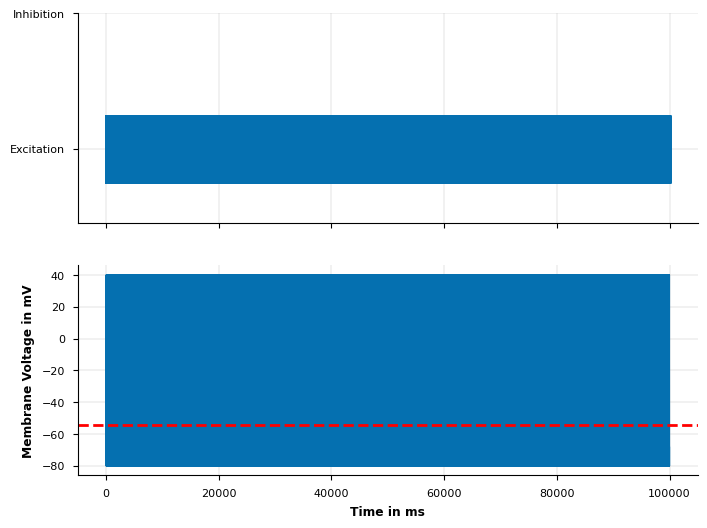

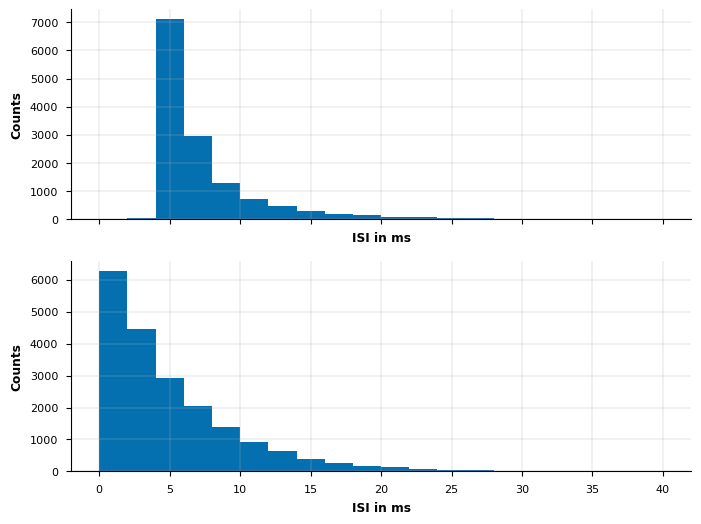

In [216]:
def transform_to_event_input(binned_spikes, bin_size=0.1):
    bin_offset = bin_size/2.
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times



output_neuron = LIFNeuron()


def create_poisson_process(time_steps, rate,dt):
    ''' this function takes an time_steps (an integer) for the lenght of the process
        the rate in Hz (1/s) of the poisson process
        and dt, the bin size (in ms)'''
    
    rate = rate*1e-3 # rate is usually given in 1/s , we need 1/ms

    x = np.zeros(time_steps)
    x[np.random.rand(time_steps) <= rate*dt] = 1
    
    _, events = transform_to_event_input(x, bin_size=dt)

    return events

def run_and_plot_simulation_for_inputs(time_steps = 10000,
                              rate_excitatory_input = 100,
                              rate_inhibitory_input = 100,
                              show_plot = True):
    dt = 0.1


    poisson_excitatory_input = create_poisson_process(time_steps, rate_excitatory_input,dt)
    poisson_inhibitory_input = create_poisson_process(time_steps, rate_inhibitory_input,dt)
    
    ampa_inputs = (poisson_excitatory_input/dt).astype(int)
    gaba_inputs = (poisson_inhibitory_input/dt).astype(int)
    neuron = LIFNeuron(g_ampa = 0.25, g_gaba = 0.25, dt=dt,  refrac_time = 0, allow_spiking=True)
    neuron.run_simulation(time_steps, 
                        ampa_inputs = ampa_inputs,
                       gaba_inputs = gaba_inputs,
                       )
    
    
    if show_plot:
        fig, (ax, ax_2) = plt.subplots(2, sharex = True)

        ax.eventplot(poisson_excitatory_input)
        ax.eventplot(poisson_inhibitory_input,lineoffsets=3, color = 'r')
        ax.set_yticks([1, 3])
        ax.set_yticklabels(['Excitation', 'Inhibition'])

        ax_2.plot(neuron.t_list,neuron.v_list,linewidth=0.8)
        ax_2.set_xlabel('Time in ms')
        ax_2.set_ylabel('Membrane Voltage in mV')
        ax_2.axhline(neuron.v_th, c='r', linestyle='--')
    
    return neuron.spike_times, poisson_excitatory_input, poisson_inhibitory_input

spike_times, excitatory_spike_times, _ = run_and_plot_simulation_for_inputs(
                              time_steps = 1_000_000,
                              rate_excitatory_input = 200,
                              rate_inhibitory_input = 0,
                            show_plot = True)

ISI = np.diff(np.array(spike_times))
ISI_excitatory = np.diff(np.array(excitatory_spike_times))

print (np.std(ISI)**2/np.mean(ISI))
print (np.std(ISI_excitatory)**2/np.mean(ISI_excitatory))

print (np.std(ISI)/np.mean(ISI))
print (np.std(ISI_excitatory)/np.mean(ISI_excitatory))

fig, (ax1, ax2) = plt.subplots(2, sharex = True)
ax1.hist(ISI, bins=np.linspace(0,40,21));
ax1.set(
    xlabel = 'ISI in ms',
    ylabel = 'Counts')

ax2.hist(ISI_excitatory, bins=np.linspace(0,40,21));
ax2.set(
    xlabel = 'ISI in ms',
    ylabel = 'Counts')


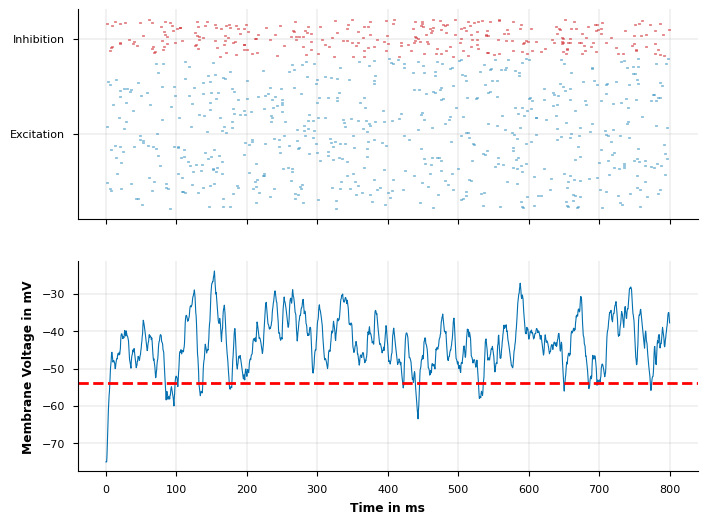

In [389]:
def run_and_plot_simulation_for_inputs(time_steps = 10000,
                              rate_excitatory_input = 100,
                              n_excitatory_inputs = 0,
                              rate_inhibitory_input = 100,
                              n_inhibitory_inputs = 0,
                              g_ampa = 0.05,
                              g_gaba = 0.05,
                              refrac_time = 0,
                              allow_spiking = True,
                              show_plot = True,
                              seed = None):
    dt = 0.5

    if seed != None:
        np.random.seed(seed)
    
    all_excitatory_inputs = []
    all_inhibitory_inputs = []
    for ii in range(n_inhibitory_inputs):
        all_inhibitory_inputs.append(create_poisson_process(time_steps, rate_inhibitory_input,dt))
    
    for ii in range(n_excitatory_inputs):
        all_excitatory_inputs.append(create_poisson_process(time_steps, rate_excitatory_input,dt))
    
    ampa_inputs = (poisson_excitatory_input/dt).astype(int)
    gaba_inputs = (poisson_inhibitory_input/dt).astype(int)
    neuron = LIFNeuron(g_ampa = g_ampa, 
                       g_gaba = g_gaba,
                       n_gaba_inputs = n_inhibitory_inputs,
                       n_ampa_inputs = n_excitatory_inputs,
                       dt=dt,  
                       refrac_time = refrac_time, 
                       allow_spiking=allow_spiking)
    neuron.run_simulation(time_steps, 
                        ampa_inputs = all_excitatory_inputs,
                       gaba_inputs = all_inhibitory_inputs,
                       )    
    
    if show_plot:
        fig, (ax, ax_2) = plt.subplots(2, sharex = True)
    
    
        for ii in range(n_excitatory_inputs):
            ax.eventplot(all_excitatory_inputs[ii], lineoffsets=ii+0.5, color = '#2b8cbe')
        for ii in range(n_inhibitory_inputs):
            ax.eventplot(all_inhibitory_inputs[ii],lineoffsets=n_excitatory_inputs + 1 + ii, color = '#cb181d')
        
        if n_inhibitory_inputs != 0:
            ax.set_yticks([n_excitatory_inputs/2., n_excitatory_inputs + n_inhibitory_inputs/2.])
            ax.set_yticklabels(['Excitation', 'Inhibition'])
        else:
            ax.set_yticks([n_excitatory_inputs/2.])
            ax.set_yticklabels(['Excitation'])

        ax_2.plot(neuron.t_list,neuron.v_list,linewidth=0.8)
        ax_2.set_xlabel('Time in ms')
        ax_2.set_ylabel('Membrane Voltage in mV')
        ax_2.axhline(neuron.v_th, c='r', linestyle='--')
        
    
    
    return neuron, all_excitatory_inputs, all_inhibitory_inputs


neuron, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = 1600,
                              rate_excitatory_input = 5,
                              n_excitatory_inputs = 160,
                              rate_inhibitory_input = 10,
                              n_inhibitory_inputs = 40,
                            show_plot = True,
                            allow_spiking = False)




# ISI = np.diff(np.array(spike_times))
# ISI_excitatory = np.diff(np.array(excitatory_spike_times))

# print (np.std(ISI)**2/np.mean(ISI))
# print (np.std(ISI_excitatory)**2/np.mean(ISI_excitatory))

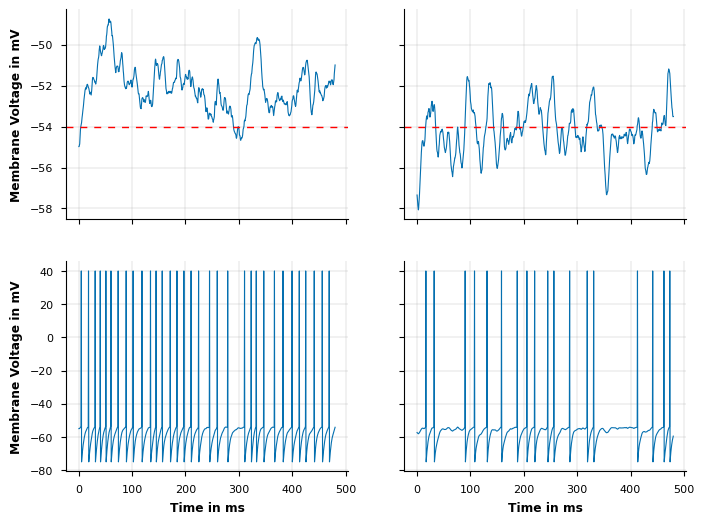

In [399]:
time_steps = 1000
rate_excitatory = 12
rate_inhibitory = 10
n_inhibitory_mean_driven = 200
n_inhibitory_fluct_driven = 200
n_excitatory = 1000
g_gaba_mean = 0.0018,
g_gaba_fluc = 0.003,
g_ampa = 0.001
neuron_mean_driven_no_spikes, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = time_steps,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_mean_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_mean,
                            show_plot = False,
                            allow_spiking = False,
                            seed = 10)

neuron_mean_driven_with_spikes, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = time_steps,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_mean_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_mean,
                            show_plot = False,
                            allow_spiking = True,
                            seed = 10)

neuron_fluct_driven_no_spikes, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = time_steps,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_fluct_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_fluc,
                            show_plot = False,
                            allow_spiking = False,
                            seed = 2)

neuron_fluct_driven_with_spikes, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = time_steps,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_fluct_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_fluc,
                            show_plot = False,
                            allow_spiking = True,
                            seed = 2)

fig, ax = plt.subplots(2,2, sharex = True, sharey='row')


time_points = np.asarray(neuron_mean_driven_no_spikes.t_list)
# cut the first 20 ms
cut_time = 20 
cut_id = np.argmax(time_points > cut_time)
ax[0,0].plot(time_points[cut_id:]-cut_time,neuron_mean_driven_no_spikes.v_list[cut_id:],linewidth=0.8)
ax[1,0].plot(time_points[cut_id:]-cut_time,neuron_mean_driven_with_spikes.v_list[cut_id:],linewidth=0.8)
ax[0,1].plot(time_points[cut_id:]-cut_time,neuron_fluct_driven_no_spikes.v_list[cut_id:],linewidth=0.8)
ax[1,1].plot(time_points[cut_id:]-cut_time,neuron_fluct_driven_with_spikes.v_list[cut_id:],linewidth=0.8)

ax[0,0].set_ylabel('Membrane Voltage in mV')
ax[1,0].set_ylabel('Membrane Voltage in mV')
ax[1,1].set_xlabel('Time in ms')
ax[1,0].set_xlabel('Time in ms')
ax[0,0].axhline(neuron.v_th, c='r', linestyle='--', dashes=(5, 5), linewidth=1)
ax[0,1].axhline(neuron.v_th, c='r', linestyle='--', dashes=(5, 5), linewidth=1)
plt.savefig('Different_spiking_regimes.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

In [400]:
neuron_mean_long, all_excitatory_inputs_long_run, all_inhibitory_inputs_long_run = run_and_plot_simulation_for_inputs(
                              time_steps = 40000,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_mean_driven,
                              g_ampa = g_ampa, 
                              g_gaba = g_gaba_mean,
                            show_plot = False,
                            allow_spiking = True,
                            seed = 10)
neuron_fluct_long, all_excitatory_inputs_long_run_fluct, all_inhibitory_inputs_long_run_fluct = run_and_plot_simulation_for_inputs(
                              time_steps = 40000,
                              rate_excitatory_input = rate_excitatory,
                              n_excitatory_inputs = n_excitatory,
                              rate_inhibitory_input = rate_inhibitory,
                              n_inhibitory_inputs = n_inhibitory_fluct_driven,
                             g_ampa = g_ampa, 
                              g_gaba = g_gaba_fluc,
                            show_plot = False,
                            allow_spiking = True,
                            seed = 2)



ISI_mean = np.diff(np.array(neuron_mean_long.spike_times))
ISI_fluct = np.diff(np.array(neuron_fluct_long.spike_times))

print (np.std(ISI_mean)**2/np.mean(ISI_mean))
print (np.std(ISI_fluct)**2/np.mean(ISI_fluct))


0.8298460583727263
12.720621549795046


0.9452725343053124
219
0.2476242180316134
1476
0.6765134547329836
717


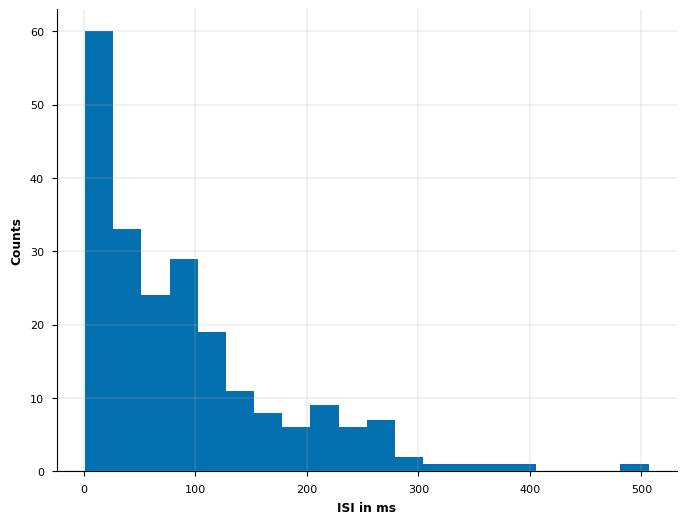

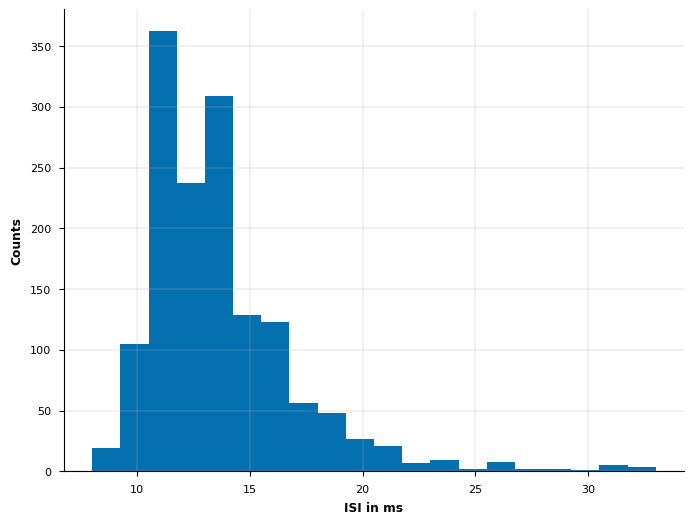

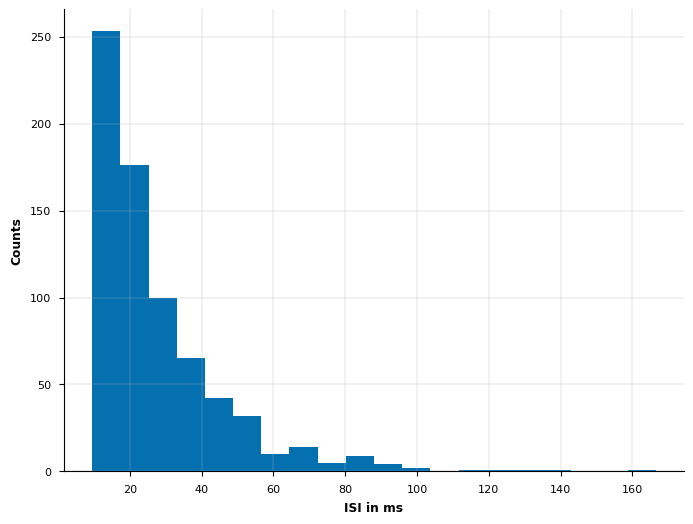

In [425]:
ISI = np.diff(np.array(all_excitatory_inputs_long_run_fluct[1]))
print (np.std(ISI)/np.mean(ISI))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    xlabel='ISI in ms',
    ylabel = 'Counts')
print (len(ISI))
plt.savefig('ISI_inputs.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )
ISI = np.diff(np.array(np.array(neuron_mean_long.spike_times)))
print (np.std(ISI)/np.mean(ISI))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    xlabel='ISI in ms',
    ylabel = 'Counts')
print (len(ISI))
plt.savefig('ISI_mean_driven.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

ISI = np.diff(np.array(np.array(neuron_fluct_long.spike_times)))
print (np.std(ISI)/np.mean(ISI))
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)
ax.set( 
    xlabel='ISI in ms',
    ylabel = 'Counts')
print (len(ISI))
plt.savefig('ISI_fluct_driven.pdf', dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

0.9729892761309635


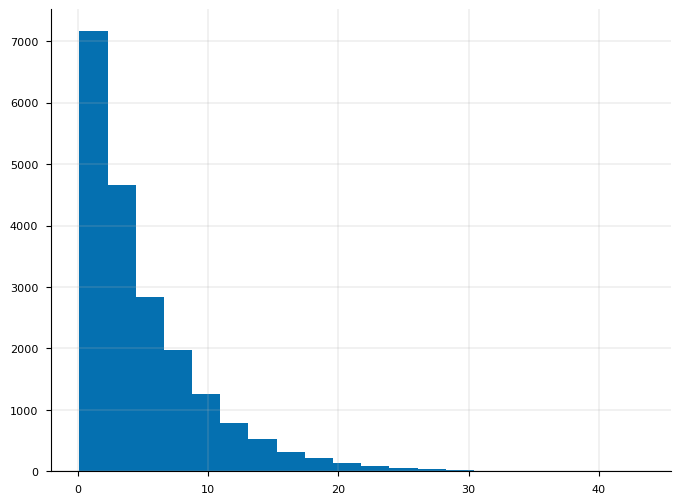

In [205]:
process = create_poisson_process(1_000_000, 200 ,0.1)
ISI = np.diff(process)
fig, ax = plt.subplots()
ax.hist(ISI, bins=20)

print(np.std(ISI)/np.mean(ISI))

In [3]:
def input_signal(rate_max_Hz=100, ipd_deg=90, f_Hz=3):
    # We can't use values with units in the widgets, so we add the units first
    rate_max = rate_max_Hz
    ipd = (pi/180)*ipd_deg
    f = f_Hz
    
    # These are the equations governing the ear neurons. Take a look at the
    # Brian documentation for an explanation, but the only thing you might
    # find non-obvious hopefully is the ": 1" and ": Hz" which tells Brian
    # what the units of the variable being defined are (1 means dimensionless).
    # Also note that the variable "i" is defined in Brian to be the index of
    # the neuron, so for neuron 0 it will be 0 and for neuron 1 it will be 1,
    # allowing us to make the input signal different for the two ears.
    eqs_ears = '''
    theta = 2*pi*f*t + i*ipd : 1
    rate = rate_max*0.5*(1+sin(theta)) : Hz
    '''
    
    # Create a group of 2 neurons with these equations, that fires a spike
    # according to a Poisson process with the given time-varying rate. We
    # use a dt of 1ms to speed up the simulation for interactivity, but later
    # we'll use a better default of 0.1ms.
    ears = NeuronGroup(2, eqs_ears, threshold='rand()<rate*dt', dt=1*ms)
    
    # Record the spikes and values of the rate as we run the simulation
    M_spike = SpikeMonitor(ears)
    M_state = StateMonitor(ears, 'rate', record=True)
    
    # Run the simulation for 1 second
    run(1*second)

    # Now plot the results. I won't explain in detail because it's mostly
    # just fiddly matplotlib stuff to make it look nice.
    trains = M_spike.spike_trains()
    fig = figure(figsize=(4, 2), dpi=200)
    gs = gridspec.GridSpec(2, 1, hspace=0, height_ratios=[1, .3])
    ax = subplot(gs[0])
    plot(M_state.t/ms, M_state.rate[0]/Hz, label='Left ear')
    plot(M_state.t/ms, M_state.rate[1]/Hz, label='Right ear')
    legend(loc='upper right')
    gca().set_frame_on(False)
    ylabel('Rate')
    yticks([])
    xticks([])
    ylim(-10, 210)
    subplot(gs[1], sharex=ax)
    plot(trains[0]/ms, [0]*len(trains[0]), '|')
    plot(trains[1]/ms, [1]*len(trains[1]), '|')
    ylim(-1, 2)
    gca().set_frame_on(False)
    xlabel('Time')
    ylabel('Spikes')
    yticks([])
    xticks([])
    tight_layout()

if widgets is not None:
    widgets.interact(input_signal,
        rate_max_Hz=widgets.IntSlider(min=10, max=200, value=100, step=10, continuous_update=False),
        ipd_deg=widgets.IntSlider(min=0, max=360, value=90, step=10, continuous_update=False),
        f_Hz=widgets.FloatSlider(min=0, max=10, value=3, step=.1, continuous_update=False),
        );
else:
    input_signal()

interactive(children=(IntSlider(value=100, continuous_update=False, description='rate_max_Hz', max=200, min=10…

In [ ]:
def poisson(n,n_expect):
    return (n_expect)**n/scipy.special.factorial(n) * np.exp(-n_expect)

fig, ax = plt.subplots()


for ii, color in zip([1,6,14],['#66c2a5','#fc8d62','#8da0cb']):
    if ii == 1:
        X = np.hstack([np.linspace(0,24)[:8],np.linspace(0,24)[8::2]])
    else:
        X = np.linspace(0,24)[::2]
    ax.plot(X,poisson(X,n_expect=ii), 
            color = 'k', marker = 'o', markersize=9, 
            markeredgecolor = 'k', markeredgewidth=1.2,
            markerfacecolor = color, label = r'$\langle n \rangle = $' + f'{ii}')

ax.set_xlabel('$n$', fontsize=18)
ax.set_ylabel('$P_T[n]$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(prop={'size': 20})

### Install brian 2
We need to install the library first before we can use it

In [2]:
try:
    import brian2
except ImportError:
    !pip install brian2
    
%matplotlib inline
from brian2 import *
import matplotlib.gridspec as gridspec

prefs.codegen.target = 'numpy'

     ------------------------------------- 966.6/966.6 kB 10.2 MB/s eta 0:00:00
     ------------------------------------- 986.3/986.3 kB 31.5 MB/s eta 0:00:00
  Using cached sympy-1.11.1-py3-none-any.whl (6.5 MB)
  Using cached mpmath-1.2.1-py3-none-any.whl (532 kB)


In [4]:
from brian2 import *

[Text(0.5, 0, 'Time in ms'), Text(0, 0.5, 'Neuron')]

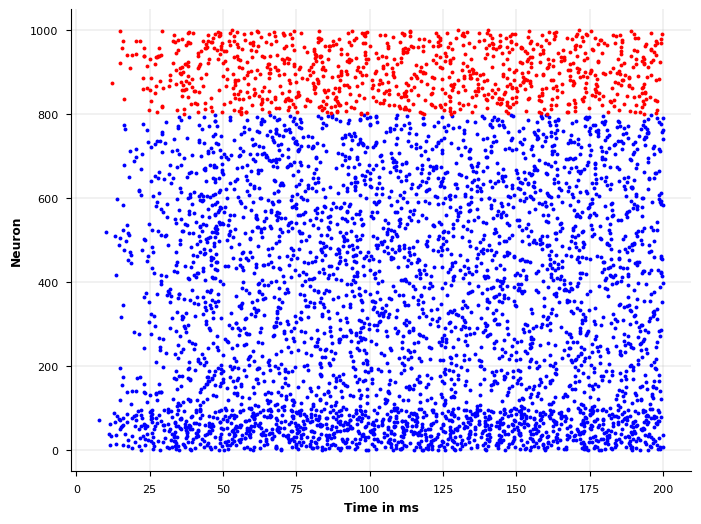

In [81]:
start_scope()

n_neurons = 1000

input_excitation = PoissonGroup(n_neurons, rates=100*Hz)
c_m = 200*pF
tau_e = 5*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -70*mV
g_l = 10*nS
v_threshold = -55 *mV
v_reset = -75*mV
eqs = '''
dv/dt = (i_e + i_i+ i_l)/c_m : volt
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
i_l = g_l * (E_l - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''
neurons_exc = NeuronGroup(n_neurons*0.8, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_inh = NeuronGroup(n_neurons*0.2, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neurons_exc.v = -80*mV
neurons_inh.v = -80*mV

excitatory_synapses = Synapses(input_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'excitatory_connections')
excitatory_synapses.connect(condition = 'i==j')
excitatory_synapses.w = 4.5*nS

inhibitory_synapses = Synapses(input_excitation,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'inhibitory_connections')
inhibitory_synapses.connect(condition = 'i==j')
inhibitory_synapses.w = 4.5*nS

e_e = Synapses(neurons_exc,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'rec_e_e')
e_e.connect(p=0.15)
e_e.w = 0.05*nS

i_e = Synapses(neurons_exc,neurons_inh, 'w : siemens', on_pre = 'g_e += w', name = 'rec_i_e')
i_e.connect(p=0.15)
i_e.w = 0.05*nS

e_i = Synapses(neurons_inh,neurons_exc, 'w : siemens', on_pre = 'g_i += w', name = 'rec_e_i')
e_i.connect(p=0.35)
e_i.w = 0.05*nS

i_i = Synapses(neurons_inh,neurons_inh, 'w : siemens', on_pre = 'g_i += w', name = 'rec_i_i')
i_i.connect(p=0.05)
i_i.w = 0.05*nS

# Create a matrix to store the weights and fill it with NaN
# W = np.full((len(neurons), len(neurons)), np.nan)
# Insert the values from the Synapses object
# W[recurrent_synapses.i[:], recurrent_synapses.j[:]] = recurrent_synapses.w[:]

# print (W)
# fig, ax = plt.subplots()
# ax.imshow(W)

specific_excitation = PoissonGroup(n_neurons*0.1, rates=100*Hz)
specific_syn = Synapses(specific_excitation,neurons_exc, 'w : siemens', on_pre = 'g_e += w', name = 'specific_connections')
specific_syn.connect(condition = 'i==j')
specific_syn.w = 4.5*nS


M_e = SpikeMonitor(neurons_exc)
M_i = SpikeMonitor(neurons_inh)



# @network_operation(dt=50*ms)
# def change_rates():
#     G.rates = rand()*500*Hz

run(200*ms)

fig, ax = plt.subplots()
ax.plot(M_e.t/ms, M_e.i, '.', c='b')
ax.plot(M_i.t/ms, M_i.i+n_neurons*0.8, '.', c='r')
ax.set(
    xlabel = 'Time in ms',
    ylabel = 'Neuron')
